In [1]:
# Stats 506, Fall 2019
# Group Project - Group 3
#
# This script analyzes the question:
# "Do people diagnosed with diabetes consume less calories in US?"
#
# NHANES 2015-2016 data are used in this problem.
#
#
# import packages
import pandas as pd
from dfply import *
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\wenji\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [66]:
# read data
demo = pd.read_sas('DEMO_I.XPT')
dr1tot = pd.read_sas('DR1TOT_I.XPT')
dr2tot = pd.read_sas('DR2TOT_I.XPT')
bmx = pd.read_sas('BMX_I.XPT')
diq = pd.read_sas('DIQ_I.XPT')
pad = pd.read_sas('PAQ_I.XPT')

In [90]:
# select columns and merge into a single dataset
demo_new = (demo >> 
            select(X.SEQN, X.RIDAGEYR, X.RIAGENDR, X.RIDEXPRG))
dr1tot_new = (dr1tot >>
              mutate(dr1 = X.DR1TKCAL) >>
              select(X.SEQN, X.dr1))
dr2tot_new = (dr2tot >>
              mutate(dr2 = X.DR2TKCAL) >>
             select(X.SEQN, X.dr2))
dietary = pd.merge(dr1tot_new, dr2tot_new, on='SEQN')
bmx_new = (bmx >>
          select(X.SEQN, X.BMXBMI))
diq_new = (diq >>
          select(X.SEQN, X.DIQ010))
pad_new = (pad >>
          select(X.SEQN, X.PAD615, X.PAD630, X.PAD680))
questionnaire = pd.merge(diq_new, pad_new, on='SEQN')
merge_2 = pd.merge(bmx_new, questionnaire, on='SEQN')
merge_3 = pd.merge(merge_2, demo_new, on='SEQN')

# exclude data without diabetes diagnosis
merge_3 = merge_3[merge_3.DIQ010 != 7 ]
merge_3 = merge_3[merge_3.DIQ010 != 9 ]

# exclude pregnant participants
merge_3 = merge_3[merge_3.RIDEXPRG != 1 ]

# create a new variable representing diabetes
  # 1 - diabetes or borderline
  # 0 - non-diabetes
diabete = []
for i in merge_3.DIQ010:
    if i == 2:
        diabete.append(0)
    else:
        diabete.append(1)
merge_3['diabetes'] = diabete

# create a new variable representing male
  # 1 - male
  # 0 - female
gender = []
for i in merge_3.RIAGENDR:
    if i == 1:
        gender.append(1)
    else:
        gender.append(0)
merge_3['gender'] = gender
merge = pd.merge(merge_3, dietary, on='SEQN')

# pivot the data into "long" format
merge = merge.melt(id_vars=merge.iloc[:,0:11], var_name='day', value_name='y')

# create a variable representing dietary interview day (1/2)
days = []
for i in merge.day:
    if i == 'dr1':
        days.append(1)
    else:
        days.append(2)
merge['day'] = days

# remove rows with missing value
merge = merge.dropna()

# Note that `age` is top-coded at 80, 
## which means participants aged 80 or older were allrecorded as age 80. 
## To avoid inaccurate data, we decided to set an age bound from 12 to 79.
merge = merge[merge["RIDAGEYR"] < 80]
merge = merge[merge["RIDAGEYR"] > 12]

# remove rows with missing value
final = merge.drop(["RIDEXPRG", "PAD615", "PAD630", "DIQ010", "RIAGENDR"], axis=1)
final_day1 = final[final["day"] == 1]
final_day2 = final[final["day"] == 2]

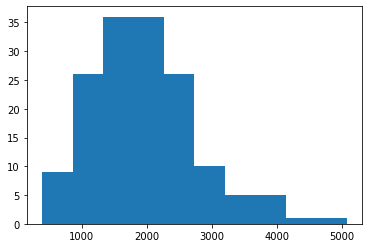

In [120]:
# check linearity for final_day1
plt.hist(final_day1["y"])
plt.savefig('Group_project_stats506_3_0.png')plt.show()

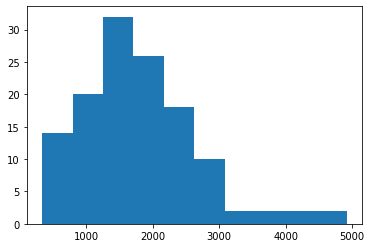

In [93]:
# check linearity for final_day1
plt.hist(final_day2["y"])
plt.savefig('Group_project_stats506_4_0.png')plt.show()

In [94]:
k2, p = stats.normaltest(final_day1['y'])
print("p = {:g}".format(p))

p = 0.000159355


In [95]:
k2, p = stats.normaltest(final_day2['y'])
print("p = {:g}".format(p))

p = 5.06948e-06


No non-linearity found.

In [111]:
# OLS model for day 1
x = sm.add_constant(final_day1[final_day1.columns[1:5]])
model = sm.OLS(final_day1['y'], x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.1695
Date:                Tue, 03 Dec 2019   Prob (F-statistic):              0.954
Time:                        23:37:40   Log-Likelihood:                -1260.1
No. Observations:                 155   AIC:                             2530.
Df Residuals:                     150   BIC:                             2545.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2047.3486    420.058      4.874      0.0

In [118]:
# Break into left and right hand side; y and X
y, X = dmatrices("y ~ BMXBMI + PAD680 + RIDAGEYR + diabetes", data=final_day1, return_type="dataframe")

# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

[39.24402833965102,
 1.032095249588678,
 1.0253815257501617,
 1.0158300005008685,
 1.0424003078079123]

No collinearity found.

In [119]:
# LMM model
mixed = smf.mixedlm("y ~ BMXBMI + PAD680 + RIDAGEYR + diabetes", final, groups = final["SEQN"])
mixed_fit = mixed.fit()
#print the summary
print(mixed_fit.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  y          
No. Observations:  283      Method:              REML       
No. Groups:        155      Scale:               429378.5852
Min. group size:   1        Likelihood:          -2278.9563 
Max. group size:   2        Converged:           Yes        
Mean group size:   1.8                                      
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1805.051  365.610  4.937 0.000 1088.468 2521.633
BMXBMI        -2.985    6.857 -0.435 0.663  -16.424   10.454
PAD680         0.047    0.367  0.129 0.898   -0.672    0.767
RIDAGEYR       4.738    8.810  0.538 0.591  -12.529   22.006
diabetes     357.817  311.786  1.148 0.251 -253.273  968.906
Group Var 293000.409  135.495                               



In [110]:
mixed_fit.random_effects

{83752.0: Group    714.014326
 dtype: float64, 83781.0: Group    218.054765
 dtype: float64, 83857.0: Group    136.60615
 dtype: float64, 83959.0: Group   -550.314443
 dtype: float64, 84033.0: Group   -79.760159
 dtype: float64, 84073.0: Group    562.812273
 dtype: float64, 84130.0: Group   -355.544879
 dtype: float64, 84187.0: Group   -210.096806
 dtype: float64, 84192.0: Group   -344.604582
 dtype: float64, 84412.0: Group    8.118748
 dtype: float64, 84440.0: Group   -381.40279
 dtype: float64, 84547.0: Group   -155.45698
 dtype: float64, 84587.0: Group    194.945027
 dtype: float64, 84716.0: Group    96.785213
 dtype: float64, 84766.0: Group   -152.005506
 dtype: float64, 84797.0: Group    1511.578945
 dtype: float64, 84816.0: Group   -0.664801
 dtype: float64, 84825.0: Group    89.080769
 dtype: float64, 84937.0: Group    161.108954
 dtype: float64, 85040.0: Group   -93.508833
 dtype: float64, 85055.0: Group    349.567852
 dtype: float64, 85132.0: Group   -305.468962
 dtype: float6